In [1]:
%matplotlib inline
import seaborn as sns

/Users/saurabh/anaconda/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [2]:
import numpy as np
import random
import datetime

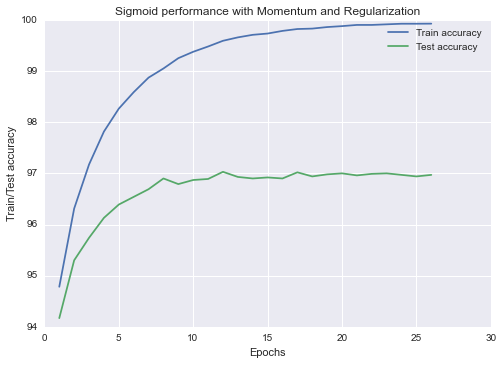

In [3]:
x = [i+1 for i in xrange(26)]
sigmoid_train =[94.783333333333331, 96.311666666666667, 97.173333333333332, 97.816666666666663, 98.265000000000001, 
                98.586666666666673, 98.87166666666667, 99.050000000000011, 99.251666666666665, 99.376666666666665, 
                99.480000000000004, 99.591666666666669, 99.658333333333331, 99.708333333333329, 99.733333333333334, 
                99.784999999999997, 99.821666666666658, 99.829999999999998, 99.859999999999999, 99.87833333333333, 
                99.901666666666671, 99.901666666666671, 99.913333333333327, 99.924999999999997, 99.924999999999997, 
                99.926666666666662]
sigmoid_test = [94.170000000000002, 95.299999999999997, 95.740000000000009, 96.13000000000001, 96.390000000000001, 
                96.540000000000006, 96.689999999999998, 96.899999999999991, 96.789999999999992, 96.870000000000005, 
                96.890000000000001, 97.030000000000001, 96.930000000000007, 96.899999999999991, 96.920000000000002, 
                96.899999999999991, 97.019999999999996, 96.939999999999998, 96.980000000000004, 97.0, 96.960000000000008, 
                96.989999999999995, 97.0, 96.969999999999999, 96.939999999999998, 96.969999999999999]

sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with Momentum and Regularization")
sns.plt.legend()

### Read MNIST

In [3]:
import os
import struct
import array
import numpy

def read(digits, dataset="training", path="."):
    """Loads MNIST files into 3D numpy arrays.
    Adapted from: http://abel.ee.ucla.edu/cvxopt/_downloads/mnist.py
    Source: http://g.sweyla.com/blog/2012/mnist-numpy/
    MNIST: http://yann.lecun.com/exdb/mnist/
    **Parameters**
        :digits: list; digits we want to load
        :dataset: string; 'training' or 'testing'
        :path: string; path to the data set files
    """

    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
    else:
        raise ValueError("dataset must be 'testing' or 'training'")

    flbl = open(fname_lbl, 'rb')
    struct.unpack(">II", flbl.read(8))
    lbl = array.array("b", flbl.read())
    flbl.close()

    fimg = open(fname_img, 'rb')
    _, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = array.array("B", fimg.read())
    fimg.close()

    ind = [k for k in xrange(size) if lbl[k] in digits]
    N = len(ind)

    images = numpy.zeros((N, rows*cols), dtype=numpy.uint8)
    labels = numpy.zeros((N, 1), dtype=numpy.int8)
    for i in xrange(len(ind)):
        images[i] = numpy.array(img[ind[i]*rows*cols:
                                (ind[i]+1)*rows*cols])
        labels[i] = lbl[ind[i]]

    return images / 255.0, labels.flatten()

In [4]:
x_train, y_train = read(list(range(10)), "training", path="data/")
x_test, y_test = read(list(range(10)), "testing", path="data/")

In [5]:
y_train_t = np.zeros((60000,10))
for i,val in enumerate(y_train):
    y_train_t[i][val] = 1

In [6]:
y_test_t = np.zeros((10000,10))
for i,val in enumerate(y_test):
    y_test_t[i][val] = 1

### Z-transforming the X matrices

In [7]:
mean = x_train.mean(axis = 0)
std = x_train.std(axis = 0, ddof = 0)
x_train = np.nan_to_num((x_train - mean) / std)
x_test = np.nan_to_num((x_test - mean) / std)

### Activation funcs and their mapping

In [8]:
sigmoid = lambda z: 1.0/(1.0+np.exp(-z))
sigmoid_prime = lambda z: sigmoid(z)*(1-sigmoid(z))
funny_tanh = lambda z: 1.7159 * np.tanh(2.0/3.0 * z) + .001*z
funny_tanh_prime = lambda z: 1.7159 * 2.0 / 3.0 * (1.0 / np.cosh(2.0/3.0 * z))**2 + .001
relu = lambda z: z * (z > 0)
relu_prime = lambda z: z >= 0
leaky_relu = lambda z: np.maximum(.1*z, z)
leaky_relu_prime = lambda z: 1*(z>=0) + .1*(z<0)

In [9]:
afunc_mapping = {
    "sigmoid": [sigmoid, sigmoid_prime],
    "tanh": [funny_tanh, funny_tanh_prime],
    "relu": [relu, relu_prime],
    "leaky_relu": [leaky_relu, leaky_relu_prime]
}

In [ ]:
x = np.linspace(-10,10,200)
sns.plt.plot(x, afunc_mapping["leaky_relu"][0](x))
sns.plt.plot(x, afunc_mapping["leaky_relu"][1](x))

In [10]:
train_data = list(zip(x_train, y_train_t))
test_data = [x_test, y_test]

### Create Neural Network class

In [11]:
class NeuralNetwork():
    def __init__(self, layers_sizes, afunc, lmbda=0):
        self.layers_num = len(layers_sizes)
        self.layers_sizes = layers_sizes
        # x -> fan-out, y-> fan-in
        self.weights = [np.random.randn(x,y)/np.sqrt(y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.biases = [np.random.randn(x) for x in layers_sizes[1:]]
        self.afunc = afunc_mapping[afunc][0]
        self.afunc_prime = afunc_mapping[afunc][1]
        self.train_accuracy = []
        self.test_accuracy = []
        self.lmbda = lmbda
        

    def forward_prop(self, x):
        activations = x
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            if i == self.layers_num:
                activations = sigmoid(W.dot(activations) + bias)
            else:
                activations = self.afunc(W.dot(activations) + bias)
        return activations
    
    def classification_accuracy(self, x_test = x_test, y_test = y_test, x_train = x_train, y_train=y_train):
        train_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_train])
        test_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_test])
        train_accuracy = sum(train_predictions == y_train) * 1.0 / len(y_train) * 100
        test_accuracy = sum(test_predictions == y_test) * 1.0 / len(y_test) * 100
        self.train_accuracy.append(train_accuracy)
        self.test_accuracy.append(test_accuracy)
        return (train_accuracy, test_accuracy)
    
    def cost_prime(self, a_L, y_true):
        """ Return the vector d(Loss) / d(a_L)"""
        return a_L - y_true
    
    def backprop(self, x, y_true):
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        activations = [x]
        zs = []
        # Forward prop
        activation = x
        
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            z = W.dot(activation) + bias
            zs.append(z)
            if i == self.layers_num:
                activation = sigmoid(z)
            else:
                activation = self.afunc(z)
            activations.append(activation)
        
        # Now do backprop
        delta = self.cost_prime(activations[-1], y_true) #* self.afunc_prime(zs[-1])
        biases_diff[-1] = delta
        weights_diff[-1] = np.outer(delta, activations[-2])
        
        for layer in xrange(2, self.layers_num):
            z = zs[-layer]
            sp = self.afunc_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            biases_diff[-layer] = delta
            weights_diff[-layer] = np.outer(delta, activations[-(layer+1)])

        return weights_diff, biases_diff
    
    def update_mini_batch(self, batch, learning_rate):
        n = len(batch)
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in batch:
            w_diff, b_diff = self.backprop(x,y)
            weights_diff = [w+dw for w, dw in zip(weights_diff, w_diff)]
            biases_diff = [b+db for b, db in zip(biases_diff, b_diff)]
            
        self.weights = [(1-learning_rate*self.lmbda)*w - learning_rate*dw/n for w,dw in zip(self.weights, weights_diff)]
        self.biases = [b - learning_rate*db/n for b,db in zip(self.biases, biases_diff)]
    
    def SGD(self, train_data = None, batch_size = 10, epochs = 10, learning_rate = .1, test_data = None):
        if test_data:
            x_test, y_test = test_data
        n = len(train_data)
        for epoch in xrange(epochs):
            if epoch >= 10:
                learning_rate *= .95
            if epoch >= 20:
                learning_rate *= .85
            random.shuffle(train_data)
            mini_batches = [train_data[i:i+batch_size] for i in xrange(0,n,batch_size)]
            
            for batch in mini_batches:
                self.update_mini_batch(batch, learning_rate)
                
            if test_data:
                print "Epoch %s: Train/test accuracy = %s" % (epoch, self.classification_accuracy() )
            else:
                print "Epoch %s" % epoch

In [12]:
class NeuralNetworkMomentum():
    def __init__(self, layers_sizes, afunc, momentum = 0):
        self.layers_num = len(layers_sizes)
        self.layers_sizes = layers_sizes
        # x -> fan-out, y-> fan-in
        if afunc in ["relu", "leaky_relu"]:
            self.weights = [np.random.randn(x,y)/np.sqrt(2.0/y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        else:
            self.weights = [np.random.randn(x,y)/np.sqrt(y) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.biases = [np.random.randn(x) for x in layers_sizes[1:]]
        self.afunc = afunc_mapping[afunc][0]
        self.afunc_prime = afunc_mapping[afunc][1]
        self.train_accuracy = []
        self.test_accuracy = []
        self.weight_momentum = [np.zeros((x,y)) for x, y in zip(layers_sizes[1:], layers_sizes[:-1])]
        self.bias_momentum = [np.zeros(x) for x in layers_sizes[1:]]
        self.momentum = momentum
        
        
    
    def forward_prop(self, x):
        activations = x
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            if i == self.layers_num:
                activations = sigmoid(W.dot(activations) + bias)
            else:
                activations = self.afunc(W.dot(activations) + bias)
        return activations
    
    def classification_accuracy(self, x_test = x_test, y_test = y_test, x_train = x_train, y_train=y_train):
        train_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_train])
        test_predictions = np.array([np.argmax(self.forward_prop(x)) for x in x_test])
        train_accuracy = sum(train_predictions == y_train) * 1.0 / len(y_train) * 100
        test_accuracy = sum(test_predictions == y_test) * 1.0 / len(y_test) * 100
        self.train_accuracy.append(train_accuracy)
        self.test_accuracy.append(test_accuracy)
        return (train_accuracy, test_accuracy)
    
    def cost_prime(self, a_L, y_true):
        """ Return the vector d(Loss) / d(a_L)"""
        return a_L - y_true
    
    def backprop(self, x, y_true):
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        activations = [x]
        zs = []
        # Forward prop
        activation = x
        
        i = 1
        for W, bias in zip(self.weights, self.biases):
            i += 1
            z = W.dot(activation) + bias
            zs.append(z)
            if i == self.layers_num:
                activation = sigmoid(z)
            else:
                activation = self.afunc(z)
            activations.append(activation)
        
        # Now do backprop
        delta = self.cost_prime(activations[-1], y_true) #* self.afunc_prime(zs[-1])
        biases_diff[-1] = delta
        weights_diff[-1] = np.outer(delta, activations[-2])
        
        for layer in xrange(2, self.layers_num):
            z = zs[-layer]
            sp = self.afunc_prime(z)
            delta = np.dot(self.weights[-layer+1].transpose(), delta) * sp
            biases_diff[-layer] = delta
            weights_diff[-layer] = np.outer(delta, activations[-(layer+1)])

        return weights_diff, biases_diff
    
    def update_mini_batch(self, batch, learning_rate):
        n = len(batch)
        weights_diff = [np.zeros(w.shape) for w in self.weights]
        biases_diff = [np.zeros(b.shape) for b in self.biases]
        
        for x, y in batch:
            w_diff, b_diff = self.backprop(x,y)
            weights_diff = [w+dw for w, dw in zip(weights_diff, w_diff)]
            biases_diff = [b+db for b, db in zip(biases_diff, b_diff)]
            
        self.weight_momentum = [(self.momentum * m) + learning_rate*dw/n for m,dw in zip(self.weight_momentum, weights_diff)]  
        self.bias_momentum = [(self.momentum * m) + learning_rate*db/n for m,db in zip(self.bias_momentum, biases_diff)]  
        
        self.weights = [w - dw for w,dw in zip(self.weights, self.weight_momentum)]
        self.biases = [b - db for b,db in zip(self.biases, self.bias_momentum)]
    
    def SGD(self, train_data = None, batch_size = 10, epochs = 10, learning_rate = .1, test_data = None):
        if test_data:
            x_test, y_test = test_data
        n = len(train_data)
        for epoch in xrange(epochs):
            if epoch >= 10:
                learning_rate *= .95
            if epoch >= 20:
                learning_rate *= .85
            random.shuffle(train_data)
            mini_batches = [train_data[i:i+batch_size] for i in xrange(0,n,batch_size)]
            
            for batch in mini_batches:
                self.update_mini_batch(batch, learning_rate)
                
            if test_data:
                print "Epoch %s: Train/test accuracy = %s" % (epoch, self.classification_accuracy() )
            else:
                print "Epoch %s" % epoch

### 2.a NN using Sigmoid (1 hidden layer)

In [13]:
clf_sigmoid_double = NeuralNetwork([784,100,10], "sigmoid")

In [14]:
clf_sigmoid_double.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 50)

Epoch 0: Train/test accuracy = (92.359999999999999, 92.400000000000006)
Epoch 1: Train/test accuracy = (93.918333333333337, 93.5)
Epoch 2: Train/test accuracy = (94.935000000000002, 94.410000000000011)
Epoch 3: Train/test accuracy = (95.518333333333345, 94.820000000000007)
Epoch 4: Train/test accuracy = (96.093333333333334, 95.140000000000001)
Epoch 5: Train/test accuracy = (96.564999999999998, 95.480000000000004)
Epoch 6: Train/test accuracy = (96.846666666666664, 95.560000000000002)
Epoch 7: Train/test accuracy = (97.14500000000001, 95.769999999999996)
Epoch 8: Train/test accuracy = (97.376666666666665, 95.939999999999998)
Epoch 9: Train/test accuracy = (97.583333333333329, 96.079999999999998)
Epoch 10: Train/test accuracy = (97.803333333333327, 96.200000000000003)
Epoch 11: Train/test accuracy = (97.998333333333335, 96.329999999999998)
Epoch 12: Train/test accuracy = (98.141666666666666, 96.5)
Epoch 13: Train/test accuracy = (98.26166666666667, 96.480000000000004)
Epoch 14: Train/te

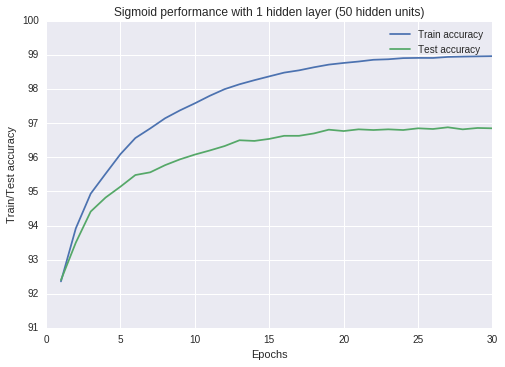

In [22]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_double.train_accuracy
sigmoid_test = clf_sigmoid_double.test_accuracy
sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 1 hidden layer (50 hidden units)")
sns.plt.legend()

### 2.b 2 hidden layers sigmoid

In [23]:
a = datetime.datetime.now()
clf_sigmoid_two_layer = NeuralNetwork([784,50,50,10], "sigmoid")
clf_sigmoid_two_layer.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 50)
b = datetime.datetime.now()
c = b - a
print "Time taken:", c.seconds

Epoch 0: Train/test accuracy = (90.016666666666666, 89.870000000000005)
Epoch 1: Train/test accuracy = (92.913333333333341, 92.560000000000002)
Epoch 2: Train/test accuracy = (94.398333333333326, 93.689999999999998)
Epoch 3: Train/test accuracy = (95.329999999999998, 94.340000000000003)
Epoch 4: Train/test accuracy = (95.896666666666661, 94.769999999999996)
Epoch 5: Train/test accuracy = (96.425000000000011, 94.920000000000002)
Epoch 6: Train/test accuracy = (96.848333333333329, 95.280000000000001)
Epoch 7: Train/test accuracy = (97.13000000000001, 95.469999999999999)
Epoch 8: Train/test accuracy = (97.453333333333333, 95.590000000000003)
Epoch 9: Train/test accuracy = (97.659999999999997, 95.620000000000005)
Epoch 10: Train/test accuracy = (97.865000000000009, 95.730000000000004)
Epoch 11: Train/test accuracy = (98.043333333333337, 95.829999999999998)
Epoch 12: Train/test accuracy = (98.203333333333333, 95.850000000000009)
Epoch 13: Train/test accuracy = (98.299999999999997, 95.950000

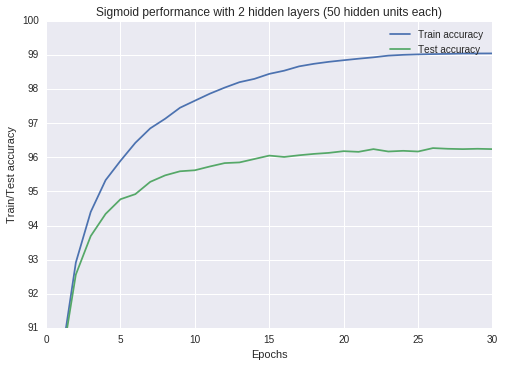

In [24]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_two_layer.train_accuracy
sigmoid_test = clf_sigmoid_two_layer.test_accuracy
sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 2 hidden layers (50 hidden units each)")
sns.plt.legend()

In [25]:
a = datetime.datetime.now()
clf_sigmoid_two_layer_half = NeuralNetwork([784,25,25,10], "sigmoid")
clf_sigmoid_two_layer_half.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 50)
b = datetime.datetime.now()
c = b - a
print "Time taken:", c.seconds

Epoch 0: Train/test accuracy = (87.058333333333337, 87.079999999999998)
Epoch 1: Train/test accuracy = (91.196666666666673, 90.670000000000002)
Epoch 2: Train/test accuracy = (92.648333333333326, 91.829999999999998)
Epoch 3: Train/test accuracy = (93.768333333333331, 92.810000000000002)
Epoch 4: Train/test accuracy = (94.478333333333325, 93.329999999999998)
Epoch 5: Train/test accuracy = (95.086666666666659, 93.820000000000007)
Epoch 6: Train/test accuracy = (95.553333333333342, 94.140000000000001)
Epoch 7: Train/test accuracy = (95.938333333333333, 94.379999999999995)
Epoch 8: Train/test accuracy = (96.165000000000006, 94.320000000000007)
Epoch 9: Train/test accuracy = (96.468333333333334, 94.670000000000002)
Epoch 10: Train/test accuracy = (96.599999999999994, 94.769999999999996)
Epoch 11: Train/test accuracy = (96.788333333333327, 94.760000000000005)
Epoch 12: Train/test accuracy = (96.974999999999994, 95.009999999999991)
Epoch 13: Train/test accuracy = (97.094999999999999, 94.95000

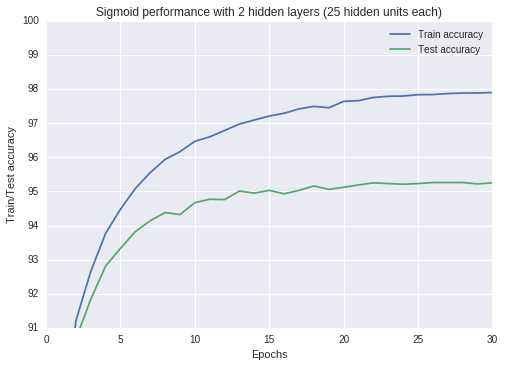

In [26]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_two_layer_half.train_accuracy
sigmoid_test = clf_sigmoid_two_layer_half.test_accuracy
sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 2 hidden layers (25 hidden units each)")
sns.plt.legend()

### Sigmoid with regularization and momentum

In [29]:
a = datetime.datetime.now()
clf_sigmoid_l1 = NeuralNetworkMomentum([784,50,10], afunc = "sigmoid", momentum=0.9)
clf_sigmoid_l1.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 50)
b = datetime.datetime.now()
c = b - a
print "Time taken:", c.seconds

Epoch 0: Train/test accuracy = (95.066666666666663, 93.969999999999999)
Epoch 1: Train/test accuracy = (96.283333333333331, 94.760000000000005)
Epoch 2: Train/test accuracy = (96.569999999999993, 94.959999999999994)
Epoch 3: Train/test accuracy = (97.090000000000003, 95.329999999999998)
Epoch 4: Train/test accuracy = (97.423333333333332, 95.260000000000005)
Epoch 5: Train/test accuracy = (97.676666666666662, 95.359999999999999)
Epoch 6: Train/test accuracy = (97.87833333333333, 95.150000000000006)
Epoch 7: Train/test accuracy = (98.031666666666666, 95.109999999999999)
Epoch 8: Train/test accuracy = (98.221666666666664, 95.509999999999991)
Epoch 9: Train/test accuracy = (98.428333333333327, 95.370000000000005)
Epoch 10: Train/test accuracy = (98.591666666666669, 95.439999999999998)
Epoch 11: Train/test accuracy = (98.743333333333339, 95.590000000000003)
Epoch 12: Train/test accuracy = (98.946666666666673, 95.549999999999997)
Epoch 13: Train/test accuracy = (99.078333333333333, 95.670000

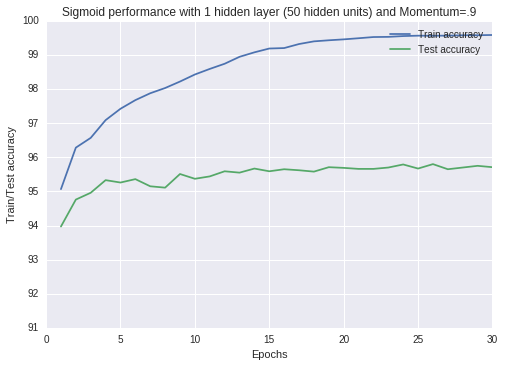

In [31]:
x = [i+1 for i in xrange(30)]
sigmoid_train = clf_sigmoid_l1.train_accuracy
sigmoid_test = clf_sigmoid_l1.test_accuracy
sns.plt.ylim([91,100])
sns.plt.xlabel("Epochs")
sns.plt.ylabel("Train/Test accuracy")
sns.plt.plot(x, sigmoid_train,  label = "Train accuracy" )
sns.plt.plot(x, sigmoid_test,  label = "Test accuracy" )
sns.plt.title("Sigmoid performance with 1 hidden layer (50 hidden units) and Momentum=.9")
sns.plt.legend()

In [ ]:
a = datetime.datetime.now()
clf_sigmoid_reg = NeuralNetwork([784,50,10], afunc = "sigmoid", lmbda=0.0001)
clf_sigmoid_reg.SGD(train_data, test_data=test_data, learning_rate = .1, epochs=30, batch_size = 50)
b = datetime.datetime.now()
c = b - a
print "Time taken:", c.seconds


Epoch 0: Train/test accuracy = (92.206666666666663, 91.840000000000003)
Epoch 1: Train/test accuracy = (93.594999999999999, 93.019999999999996)
Epoch 2: Train/test accuracy = (94.531666666666666, 93.629999999999995)
Epoch 3: Train/test accuracy = (95.023333333333341, 94.170000000000002)
Epoch 4: Train/test accuracy = (95.484999999999999, 94.439999999999998)